In [2]:
import numpy as np
import cv2
# from moviepy.editor import VideoFileClip
from IPython.display import clear_output, Image, display, HTML
import matplotlib.pyplot as plt
import pysindy as ps

In [26]:
# desired video to work with
video = cv2.VideoCapture("C:/Users/laure/Documents/ARA/laurd_ara/video_processing/fxd_low_1.MP4")

# set number of frames to average


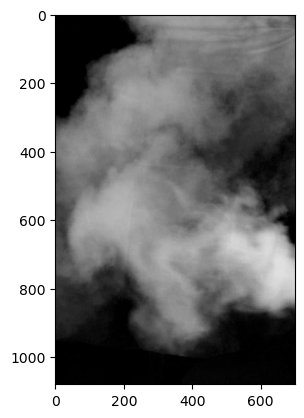

In [16]:
ret, frame = video.read()

# frames_array = np.zeros(())
background_img_np =frame.astype(float)

plt.figure()
plt.imshow(background_img_np[:,800:1500]/255)
plt.show()

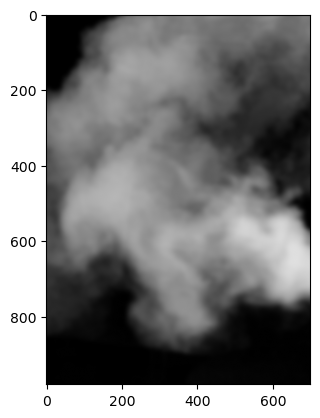

In [19]:
blur_frame = cv2.GaussianBlur(frame,ksize=(0,0), sigmaX=5)

plt.figure()
plt.imshow(blur_frame.astype(float)[100:,800:1500]/255)
plt.show()

In [11]:
blur_frame.shape

(900, 700)

In [39]:
video = cv2.VideoCapture("C:/Users/laure/Documents/ARA/laurd_ara/video_processing/fxd_low_1.MP4")
img_count = 100
ret, frame = video.read()
frame_width = 700
frame_height = 900


spatial_subsample = 5
# background_img_np =cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(float)
all_frames = np.zeros((frame_height//spatial_subsample,frame_width//spatial_subsample,img_count))

# sum up the frames in B&W in the form of numpy arrays
# takes 'img_count' frames from the beginnning of the video clip
k=0
try:
    while ret:
        if k<img_count:
            # background_img_np += cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(float)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(float)
            blur_frame = cv2.GaussianBlur(frame[100:-80:spatial_subsample,800:1500:spatial_subsample],ksize=(0,0), sigmaX=5)

            all_frames[:,:,k] = blur_frame
        k+=1
        ret, frame = video.read()
except KeyboardInterrupt:
    pass
finally:
    video.release()

# takes average
# background_img_np = (background_img_np/img_count).astype(np.uint8)

#save numpy array if desired for later use
#np.save("low_1_fixed_bg.npy", background_img_np)


In [40]:
all_frames = all_frames - np.mean(all_frames)
all_frames = all_frames/np.std(all_frames)

In [41]:
all_frames.shape

(180, 140, 100)

In [42]:


# u = x.reshape((x.shape[0],x.shape[1],-1,1))
u= all_frames.reshape((all_frames.shape[0],all_frames.shape[1],-1,1))
# u[:, :, :, 0] = u_sol
# u[:, :, :, 1] = v_sol
u_dot = ps.FiniteDifference(axis=2)._differentiate(u, t=1)

t=np.arange(u.shape[2])
x= np.arange(u.shape[1])
y = np.arange(u.shape[0])
X, Y = np.meshgrid(x, y)


# Choose 60 % of data for training because data is big...
# can only randomly subsample if you are passing u_dot to model.fit!!!
# train = np.random.choice(len(t), int(len(t) * 0.6), replace=False)
# test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, :, :, :]
# u_test = u[:, :, test, :]
u_dot_train = u_dot[:, :, :, :]
# u_dot_test = u_dot[:, :, test, :]
t_train = t#[train]
# t_test = t[test]
spatial_grid = np.asarray([X, Y]).T

In [43]:
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    #periodic=True
)


In [44]:
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()

# inputs_per_library = np.array([[0,1],[0,1],[0,0]])
tensor_array = [[1, 1, 0]]

In [45]:
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library, pde_lib],
    tensor_array=tensor_array,
    # inputs_per_library=inputs_per_library,
)


In [37]:
thresh=1e-1
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3,max_iter=100)

model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train,ensemble=True)
model.print()
# u_dot_stlsq = model.predict(u_test)

STLSQ model: 


c:\Users\laure\anaconda3\lib\site-packages\pysindy\pysindy.py:305: UserWarning: Ensembling arguments are deprecated.Use the EnsembleOptimizer class instead.
  warnings.warn(
c:\Users\laure\anaconda3\lib\site-packages\pysindy\optimizers\base.py:289: UserWarning: n_models must be a positive integer.  Explicitly initialized to zero or None, defaulting to 20.
  warnings.warn(


(x0)' = 0.570 x0_2 + -0.093 x0_22 + 0.184 x0_1 + 0.405 x0_11 + 0.160 x0x0_2 + -0.395 x0x0_11


In [47]:
thresh=1e-1
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3,max_iter=100)

model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train,ensemble=True)
model.print()
# u_dot_stlsq = model.predict(u_test)

STLSQ model: 


c:\Users\laure\anaconda3\lib\site-packages\pysindy\pysindy.py:305: UserWarning: Ensembling arguments are deprecated.Use the EnsembleOptimizer class instead.
  warnings.warn(
c:\Users\laure\anaconda3\lib\site-packages\pysindy\optimizers\base.py:289: UserWarning: n_models must be a positive integer.  Explicitly initialized to zero or None, defaulting to 20.
  warnings.warn(


(x0)' = 1.461 x0_2 + -0.494 x0_22 + 0.493 x0_1 + 0.687 x0_11 + 0.504 x0x0_2 + 0.588 x0x0_12 + -1.583 x0x0_11


In [48]:
video = cv2.VideoCapture("C:/Users/laure/Documents/ARA/laurd_ara/video_processing/fxd_low_1.MP4")
img_count = 100
ret, frame = video.read()
frame_width = 700
frame_height = 900


spatial_subsample = 5
# background_img_np =cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(float)
all_frames = np.zeros((frame_height//spatial_subsample,frame_width//spatial_subsample,img_count))

# sum up the frames in B&W in the form of numpy arrays
# takes 'img_count' frames from the beginnning of the video clip
k=0
try:
    while ret:
        if k<img_count:
            # background_img_np += cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(float)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(float)
            # blur_frame = cv2.GaussianBlur(frame[100:-80:spatial_subsample,800:1500:spatial_subsample],ksize=(0,0), sigmaX=5)

            all_frames[:,:,k] = frame[100:-80:spatial_subsample,800:1500:spatial_subsample]
        k+=1
        ret, frame = video.read()
except KeyboardInterrupt:
    pass
finally:
    video.release()

# takes average
# background_img_np = (background_img_np/img_count).astype(np.uint8)

#save numpy array if desired for later use
#np.save("low_1_fixed_bg.npy", background_img_np)


In [49]:
all_frames = all_frames - np.mean(all_frames)
all_frames = all_frames/np.std(all_frames)

In [50]:
all_frames.shape

(180, 140, 100)

In [51]:


# u = x.reshape((x.shape[0],x.shape[1],-1,1))
u= all_frames.reshape((all_frames.shape[0],all_frames.shape[1],-1,1))
# u[:, :, :, 0] = u_sol
# u[:, :, :, 1] = v_sol
u_dot = ps.FiniteDifference(axis=2)._differentiate(u, t=1)

t=np.arange(u.shape[2])
x= np.arange(u.shape[1])
y = np.arange(u.shape[0])
X, Y = np.meshgrid(x, y)


# Choose 60 % of data for training because data is big...
# can only randomly subsample if you are passing u_dot to model.fit!!!
# train = np.random.choice(len(t), int(len(t) * 0.6), replace=False)
# test = [i for i in np.arange(len(t)) if i not in train]
u_train = u[:, :, :, :]
# u_test = u[:, :, test, :]
u_dot_train = u_dot[:, :, :, :]
# u_dot_test = u_dot[:, :, test, :]
t_train = t#[train]
# t_test = t[test]
spatial_grid = np.asarray([X, Y]).T

In [52]:
library_functions = [
    lambda x: x,
    lambda x: x * x * x,
    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda x: x,
    lambda x: x + x + x,
    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    #periodic=True
)


In [53]:
poly_library = ps.PolynomialLibrary(include_bias=False)
fourier_library = ps.FourierLibrary()

# inputs_per_library = np.array([[0,1],[0,1],[0,0]])
tensor_array = [[1, 1, 0]]

In [54]:
generalized_library = ps.GeneralizedLibrary(
    [poly_library, fourier_library, pde_lib],
    tensor_array=tensor_array,
    # inputs_per_library=inputs_per_library,
)


In [56]:
thresh=1e-1
print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=thresh, alpha=1e-3,max_iter=100)

model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer)
model.fit(u_train, x_dot=u_dot_train,ensemble=True)
model.print()
# u_dot_stlsq = model.predict(u_test)

STLSQ model: 


c:\Users\laure\anaconda3\lib\site-packages\pysindy\pysindy.py:305: UserWarning: Ensembling arguments are deprecated.Use the EnsembleOptimizer class instead.
  warnings.warn(
c:\Users\laure\anaconda3\lib\site-packages\pysindy\optimizers\base.py:289: UserWarning: n_models must be a positive integer.  Explicitly initialized to zero or None, defaulting to 20.
  warnings.warn(


(x0)' = 0.968 x0_2 + 0.419 x0_1 + 0.362 x0x0_2 + 0.154 x0x0_1 + -0.008 x0x0x0x0_1 + 0.085 x0x0_12 + -0.023 x0x0x0x0_12
